References:
1.   https://machinelearningmastery.com/develop-a-caption-generation-model-in-keras/
2.   https://github.com/hlamba28/Automatic-Image-Captioning/blob/master/Automatic%20Image%20Captioning.ipynb
3.   https://datascience.stackexchange.com/questions/29480/uploading-images-folder-from-my-system-into-google-colab
4.   https://stackoverflow.com/questions/24906126/how-to-unpack-pkl-file
5.   https://keras.io/preprocessing/text/



In [1]:
from os import listdir
from numpy import array, argmax
from pandas import DataFrame

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array 
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from pickle import load
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, LSTM, RepeatVector, Embedding
from keras.layers.merge import concatenate

Using TensorFlow backend.


Extract Photo Features using pretrained VGG16 and save the extracted features into a pickle file
( Reference : https://machinelearningmastery.com/develop-a-caption-generation-model-in-keras/ )

**Execute this cell once**

In [0]:
def extract_features(directory):
	model = VGG16()	# load the pretrained model
	model.layers.pop()	# re-structure the model
	model_input = model.inputs
	model_output = model.layers[-1].output
	model = Model(inputs = model_input, outputs = model_output)
	print(model.summary())
	
	# extract features
	features = {}
	for name in listdir(directory):
		filename = directory + '/' + name
		image = load_img(filename, target_size=(224, 224))
		image = img_to_array(image)
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		image = preprocess_input(image)
		feature = model.predict(image, verbose=0)
		image_id = name.split('.')[0]
		features[image_id] = feature
	return features

# extract features from all images
directory = '/content/drive/My Drive/Flicker8k_Dataset'
features = extract_features(directory)
dump(features, open('/content/drive/My Drive/image_features.pkl', 'wb'))

Extract image descriptions and store them in a text file

**Execute this cell once**

In [0]:
def extract_and_save_descriptions():
	token_filename = '/content/drive/My Drive/Flickr8k_text/Flickr8k.token.txt'
	file = open(token_filename, 'r')
	data = file.read()
	file.close()

	descriptions = dict()
	splitData = data.split('\n')
	for line in splitData:
		tokens = line.split()
		if len(line) < 2:
			continue
		image_id, image_desc = tokens[0], tokens[1:]
		image_id = image_id.split('.')[0]
		image_desc = ' '.join(image_desc)
		if image_id not in descriptions:
			descriptions[image_id] = list()
		descriptions[image_id].append(image_desc)
		
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open('/content/drive/My Drive/image_descriptions.txt', 'w')
	file.write(data)
	file.close()

	return descriptions

descriptions = extract_and_save_descriptions()

Model architecture - adding more LSTM layers gives better results

In [0]:
def captioning_model(vocabulary, max_length):
	# Encoder
	first_input_layer = Input(shape=(4096,))
	extractor1 = Dense(128, activation='relu')(first_input_layer)
	extractor2 = RepeatVector(max_length)(extractor1)
 
	# Embedding layer
	embedding_layer = Input(shape=(max_length,))
	embedder2 = Embedding(vocabulary, 50, mask_zero=True)(embedding_layer)
	embedder3 = LSTM(256, return_sequences=True)(embedder2)
	embedder4 = LSTM(256, return_sequences=True)(embedder3)
	embedder5 = Dense(128, activation='relu')(embedder4)
	
	merged_layer = concatenate([extractor2, embedder5])
	
	#Decoder
	decoder1 = LSTM(500)(merged_layer)
	decoder2 = Dense(500, activation='relu')(decoder1)
	outputs = Dense(vocabulary, activation='softmax')(decoder2)
	model = Model(inputs=[first_input_layer, embedding_layer], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

Generate data for each image, generates sequences of input words and output words for each image

In [0]:
def generate_data(descriptions, features, tokenizer, max_length, n_step):
	while 1:
		keys = list(descriptions.keys())
		for i in range(0, len(keys), n_step):
			return_image = []
			return_sequence = []
			return_y = []
			for j in range(i, min(len(keys), i+n_step)):
				image_id = keys[j]
				image = features[image_id][0]
				desc = descriptions[image_id]
				input_image = []
				input_seq = []
				output_word = []

				vocabulary = len(tokenizer.word_index) + 1
				seq = tokenizer.texts_to_sequences([desc])[0]
				for i in range(1, len(seq)):
					input_ = seq[:i]
					output_ = seq[i]
					input_ = pad_sequences([input_], maxlen=max_length)[0]
					output_ = to_categorical([output_], num_classes=vocabulary)[0]
					input_image.append(image)
					input_seq.append(input_)
					output_word.append(output_)

				for k in range(len(input_image)):
					return_image.append(input_image[k])
					return_sequence.append(input_seq[k])
					return_y.append(output_word[k])
					
			yield [[array(return_image), array(return_sequence)], array(return_y)]

Generate image description

In [0]:
def generate_image_description(model, tokenizer, photo, max_length):
	text = 'uniquestart'	#start token
	for i in range(max_length):
		sequence = tokenizer.texts_to_sequences([text])[0]	#encode the sequence
		sequence = pad_sequences([sequence], maxlen=max_length)
		prediction = model.predict([photo,sequence], verbose=0)	#predict next word based on encoded sequence
		prediction = argmax(prediction)
	
		# map integer to back to word
		word = None
		for w, index in tokenizer.word_index.items():
			if index == prediction:
				word =  w
				break

		if word is None:	#stop if we cannot map the word
			break
		text += ' ' + word
		if word == 'uniqueend':	#stop if end token is encountered
			break
	return text

Evaluate the model using BLEU score

In [0]:
def get_blue_score(model, descriptions, photos, tokenizer, max_length):
	print("evaluating..")
	actual = []
	predicted = []

	for key, desc in descriptions.items():
		prediction = generate_image_description(model, tokenizer, photos[key], max_length)
		actual.append([desc.split()])
		predicted.append(prediction.split())
	
	#calculate BLEU score (add smoothing function)
	cc = SmoothingFunction()
	bleu = corpus_bleu(actual, predicted, smoothing_function = cc.method4)
	return bleu

Load train and test datasets

In [0]:
train_filename = '/content/drive/My Drive/Flickr8k_text/Flickr_8k.trainImages.txt'
file = open(train_filename, 'r')
data = file.read()
file.close()

train = list()
splitData = data.split('\n')
for line in splitData:
  if len(line) < 1:
    continue
  splitLine = line.split('.')[0]
  train.append(splitLine)

train = set(train)

test_filename = '/content/drive/My Drive/Flickr8k_text/Flickr_8k.testImages.txt'
file = open(test_filename, 'r')
data = file.read()
file.close()

test = list()
splitData = data.split('\n')
for line in splitData:
  if len(line) < 1:
    continue
  splitLine = line.split('.')[0]
  test.append(splitLine)

test = set(test)

Clean descriptions - remove punctuations

In [0]:
#Get cleaned descriptions
file = open('/content/drive/My Drive/image_descriptions.txt', 'r')
doc = file.read()
file.close()

train_descriptions = {}
splitData = doc.split('\n')
for line in splitData:
  tokens = line.split()
  image_id = tokens[0]
  image_desc = tokens[1:]
  if image_id in train:
    start = 'uniquestart '
    end = ' uniqueend'
    content = ' '.join(image_desc)
    value = start + content + end
    train_descriptions[image_id] = value

test_descriptions = {}
splitData = doc.split('\n')
for line in splitData:
  tokens = line.split()
  image_id = tokens[0]
  image_desc = tokens[1:]
  if image_id in test:
    start = 'uniquestart '
    end = ' uniqueend'
    content = ' '.join(image_desc)
    value = start + content + end
    test_descriptions[image_id] = value

#Get train and test image features
data = load(open('/content/drive/My Drive/image_features.pkl', 'rb'))
train_features = {t: data[t] for t in train}
test_features = {t: data[t] for t in test}

Convert words to vectors using tokenizer - generate sequence of integers (https://keras.io/preprocessing/text/)

In [0]:
#prepare tokenizer
lines = list(train_descriptions.values())
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)

vocabulary = len(tokenizer.word_index) + 1
max_length = max(len(s.split()) for s in list(train_descriptions.values()))

In [0]:
print ("WORD  INTEGER")
for x in list(tokenizer.word_docs)[0:5]:
    print ("{} -> {} ".format(x,  tokenizer.word_docs[x]))

WORD  INTEGER
wooden -> 45 
into -> 161 
cabin -> 1 
going -> 26 
dress -> 56 


Train the captioning model

In [0]:
import os.path
from os import path

saved_model_path = '/content/drive/My Drive/Weights/best_model.h5'
if path.exists(saved_model_path):
  model = load_model(saved_model_path)
else:
  model = captioning_model(vocabulary, max_length)

epochs = 1
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

for i in range(epochs):
    generator = generate_data(train_descriptions, train_features, tokenizer, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/My Drive/Weights/best_model.h5')

BLEU evaluation of train and test images - save evaluation results into a csv file

In [0]:
# define experiment
model_name = 'cap'

saved_model_path = '/content/drive/My Drive/Weights/best_model.h5'
model = load_model(saved_model_path)

# evaluate model on training data
train_score = get_blue_score(model, train_descriptions, train_features, tokenizer, max_length)
test_score = get_blue_score(model, test_descriptions, test_features, tokenizer, max_length)
print_images(model, test_features, tokenizer, max_length)
# store
print('train_score = %f, test_score = %f' % (train_score, test_score))

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
for x in list(load_test_features)[0:1]:
    print ("key : {}, \nvalue : {} ".format(x,  load_test_features[x]))

key : 1020651753_06077ec457, 
value : [[0.         0.         1.1434925  ... 0.         0.20157868 3.238835  ]] 


Final cell to display the results

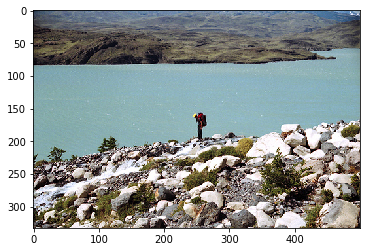

the rock climber is hiking up mountain


In [0]:
import matplotlib.pyplot as plt

train_filename = '/content/drive/My Drive/Flickr8k_text/Flickr_8k.trainImages.txt'
file = open(train_filename, 'r')
data = file.read()
file.close()

train = list()
splitData = data.split('\n')
for line in splitData:
  if len(line) < 1:
    continue
  splitLine = line.split('.')[0]
  train.append(splitLine)

train = set(train)

test_filename = '/content/drive/My Drive/Flickr8k_text/Flickr_8k.testImages.txt'
file = open(test_filename, 'r')
data = file.read()
file.close()

test = list()
splitData = data.split('\n')
for line in splitData:
  if len(line) < 1:
    continue
  splitLine = line.split('.')[0]
  test.append(splitLine)

test = set(test)

load_test_features = load(open('/content/drive/My Drive/image_features.pkl', 'rb'))
test_features = {t: load_test_features[t] for t in test}

file = open('/content/drive/My Drive/image_descriptions.txt', 'r')
readDescriptions = file.read()
file.close()

train_descriptions = {}
splitDoc = readDescriptions.split('\n')
for d in splitDoc:
  get_tokens = d.split()
  image_id = get_tokens[0] 
  image_desc = get_tokens[1:]
  if image_id in train:
    start = 'uniquestart '
    end = ' uniqueend'
    description_content = ' '.join(image_desc)
    value = start + description_content + end
    train_descriptions[image_id] = value

lines = list(train_descriptions.values())
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)

max_length = max(len(s.split()) for s in list(train_descriptions.values()))

def print_images(model, photos, tokenizer, max_length):
  z = 74
  pic = list(photos.keys())[z]
  image = photos[pic].reshape((1,4096))
  x=plt.imread('/content/drive/My Drive/output_dataset/Flicker8k_Dataset/' + pic + '.jpg')
  plt.imshow(x)
  plt.show()
  text = generate_image_description(model, tokenizer, image, max_length)
  text = text.split()
  print(' '.join(text[1:-1]))

model = load_model('/content/drive/My Drive/Weights/best_model.h5')
print_images(model, test_features, tokenizer, max_length)